In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



## load the data:



In [2]:
df = pd.read_csv('housing.csv')
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [3]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

- Apply the log tranform to price</br>
- Do train/validation/test split with 60%/20%/20% distribution.</br>
- Use the train_test_split function and set the random_state parameter to 1</br>

In [4]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value)
y_val = np.log1p(df_val.median_house_value)
y_test = np.log1p(df_test.median_house_value)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [5]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [6]:
from sklearn.feature_extraction import DictVectorizer

In [7]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


# Question 1

####   Let's train a decision tree regressor to predict the price variable.


- Train a model with max_depth=1



In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



 Which feature is used for splitting the data?

- ## ocean_proximity=INLAND</br>
- total_rooms</br>
- latitude</br>
- population</br>

# Question 2

Train a random forest model with these parameters:</br>

- n_estimators=10</br>
- random_state=1</br>
- n_jobs=-1 (optional - to make training faster)</br>

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24545397046300327

What's the RMSE of this model on validation?</br>

- 0.05</br>
- ## 0.25</br>
- 0.55</br>
- 0.85</br>

# Question 3


Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10</br>
- Set random_state to 1</br>
- Evaluate the model on the validation dataset</br>

In [15]:
from tqdm.auto import tqdm

In [16]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

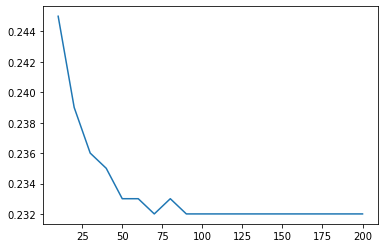

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

After which value of n_estimators does RMSE stop improving?</br>

- 10</br>
- 55</br>
- # 75</br>
- 150</br>

# Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]</br>
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)</br>
- Fix the random seed: random_state=1</br>

In [18]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

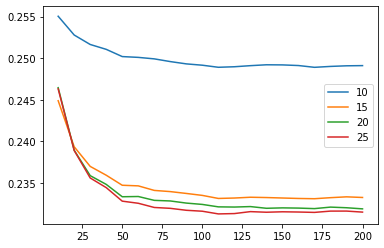

In [19]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

What's the best max_depth:</br>

- 10</br>
- # 15</br>
- 20</br>
- 25</br>

# Question 5

We can extract feature importance information from tree-based models.</br>

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.</br>

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.</br>

For this homework question, we'll find the most important feature:</br>

- Train the model with these parametes:</br>
    - n_estimators=10,</br>
    - max_depth=20,</br>
    - random_state=1,</br>
    - n_jobs=-1 (optional)</br>
- Get the feature importance information from this model</br>

In [219]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [220]:
rf.feature_importances_

array([1.71689849e-02, 3.31052275e-02, 1.01310335e-01, 9.63115091e-02,
       3.63080204e-01, 2.98751309e-03, 3.10900842e-01, 3.56806263e-04,
       4.29328159e-04, 4.24278366e-03, 3.09603695e-02, 1.86339662e-02,
       2.05121310e-02])

In [221]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,households,0.017169
1,housing_median_age,0.033105
2,latitude,0.101310
3,longitude,0.096312
4,median_income,0.363080
5,ocean_proximity=<1H OCEAN,0.002988
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000429
9,ocean_proximity=NEAR OCEAN,0.004243


In [222]:

df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.363080
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101310
3,longitude,0.096312
1,housing_median_age,0.033105


What's the most important feature?</br>

- total_rooms</br>
- ## median_income</br>
- total_bedrooms</br>
- longitude</br>

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter</br>

- Install XGBoost</br>
- Create DMatrix for train and validation</br>
- Create a watchlist</br>
- Train a model with these parameters for 100 rounds:</br>

xgb_params = {</br>
    'eta': 0.3,</br> 
    'max_depth': 6,</br>
    'min_child_weight': 1,</br>
    
    'objective': 'reg:squarederror',</br>
    'nthread': 8,</br>
    
    'seed': 1,</br>
    'verbosity': 1,</br>
}

In [223]:
import xgboost as xgb

In [224]:
features = dv.feature_names_

In [225]:
import re

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

In [226]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=_1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [227]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [228]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [229]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [230]:
scores = {}

In [231]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [232]:

scores['eta=0.3'] = parse_xgb_output(output)


Now change eta first to 0.1 and then to 0.01

In [233]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [234]:
scores['eta=0.1'] = parse_xgb_output(output)

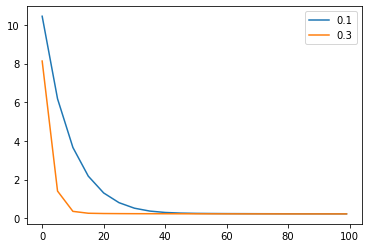

In [235]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

#plt.ylim([0.43, 0.45])
#plt.xlim([50, 100])

Which eta leads to the best RMSE score on the validation dataset?

- 0.3</br>
- 0.1</br>
- ## Both gives same</br>